# Preparation

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load packages
import time
import bilby
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Global settings
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
RANDOM_SEED = random.randint(0, 2 ** 32 - 1)
print(f'Random seed: {RANDOM_SEED}')

Random seed: 2743408526


# Data preprocessing

In [4]:
# Read dataset
df = pd.read_csv('richers_1764_rescale.csv')
df

,V1,V2,V3,V4,V5,...,V1760,V1761,V1762,V1763,V1764
0,2.299923e-24,2.527552e-24,8.059576e-26,8.059576e-26,1.324238e-26,...,7.399417e-23,5.610661e-23,6.739103e-23,2.169064e-23,7.420147e-23
1,2.274268e-24,2.328567e-24,1.685544e-25,1.685544e-25,-1.650060e-26,...,7.442206e-23,5.582889e-23,6.721437e-23,2.271645e-23,7.454020e-23
2,2.215221e-24,2.094705e-24,2.347813e-25,2.347813e-25,4.048202e-26,...,7.484044e-23,5.560609e-23,6.712178e-23,2.374041e-23,7.487463e-23
3,2.093637e-24,1.918494e-24,2.730109e-25,2.730109e-25,1.783832e-25,...,7.522720e-23,5.542156e-23,6.705519e-23,2.473439e-23,7.519551e-23
4,1.931758e-24,1.877092e-24,2.383618e-25,2.383618e-25,3.779567e-25,...,7.551948e-23,5.529326e-23,6.694590e-23,2.572290e-23,7.552503e-23
...,...,...,...,...,...,...,...,...,...,...,...
402,1.025202e-22,-8.179621e-23,1.142098e-22,1.255302e-22,8.970504e-23,...,-1.936798e-23,2.322337e-24,-3.576105e-24,5.322883e-25,-5.358647e-24
403,7.675234e-23,-5.137418e-23,8.207249e-23,1.592652e-22,9.991123e-23,...,-1.517759e-23,1.149651e-24,-3.020063e-24,5.374753e-25,-2.042285e-24
404,4.525653e-23,-1.708020e-23,5.817406e-23,1.748412e-22,1.049295e-22,...,-1.101897e-23,4.567120e-25,-2.594839e-24,2.642082e-25,1.025339e-24
405,2.317868e-23,2.274600e-23,4.686491e-23,1.873622e-22,1.014973e-22,...,-9.233160e-24,-1.277887e-24,-2.088333e-24,9.534890e-27,1.917679e-24


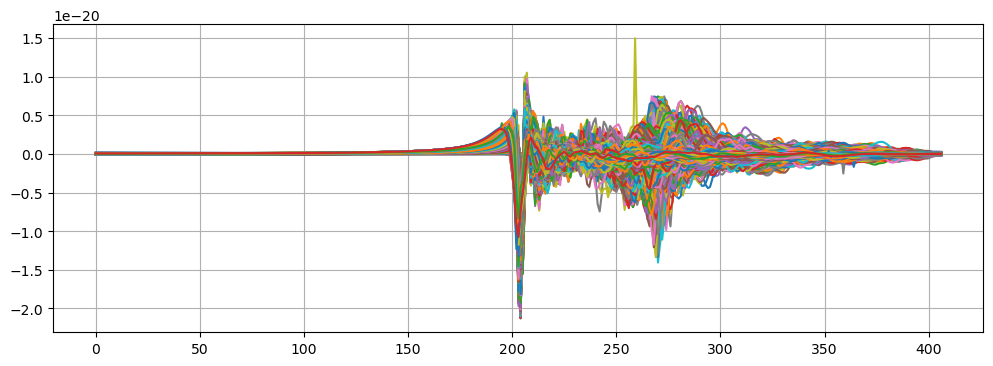

In [5]:
# Plot all signals
df.plot.line(figsize = (12, 4), grid = True, legend = False)
plt.show()

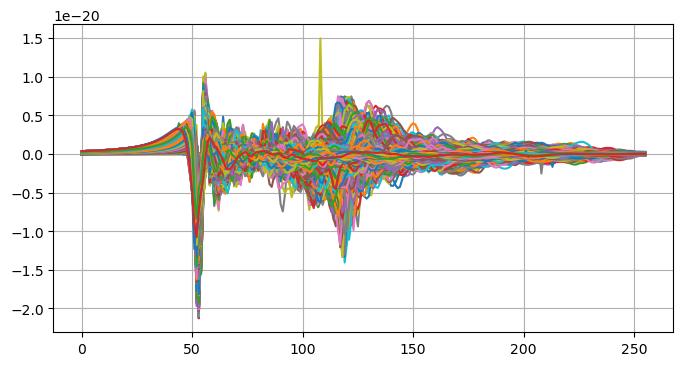

In [6]:
# Filter out flat signals
df = df[151:].reset_index(drop = True)
df.plot.line(figsize = (8, 4), grid = True, legend = False)
plt.show()

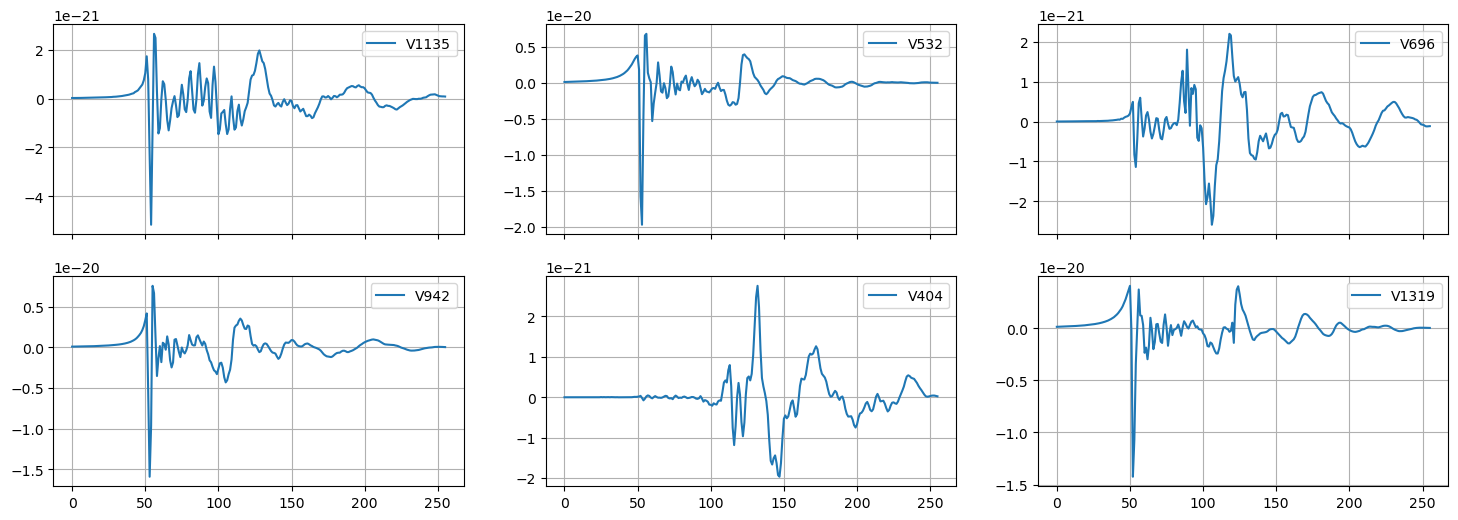

In [7]:
# Plot signals individually
V = ['V' + str(x) for x in random.sample(range(1, df.shape[1] + 1), 6)]
df.plot(y = V, figsize = (18, 6), grid = True, subplots = True, layout = (2, 3), color = 'C0')
plt.show()

In [8]:
# def white_noise_generator(signal, snr = 20):
#     signal_power = np.mean(signal ** 2)
#     noise_power = signal_power / 10 ** (snr/10)
#     return np.random.normal(loc = 0, scale = np.sqrt(noise_power), size = len(signal))

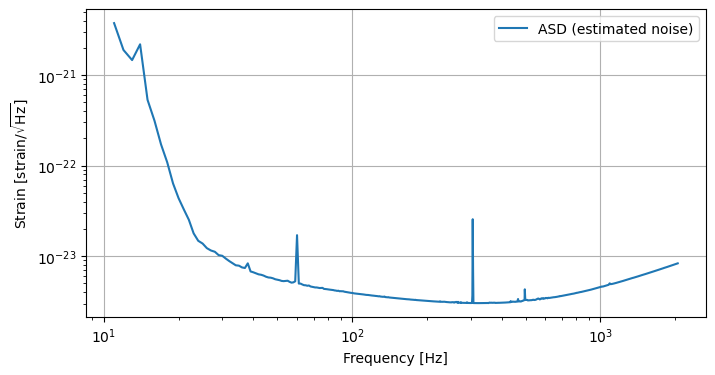

In [9]:
# Noise from LIGO-Hanford (H1)
ifos = bilby.gw.detector.InterferometerList(['H1'])
ifos.set_strain_data_from_power_spectral_densities(sampling_frequency = 4096, duration = 1, start_time = 0)
plt.figure(figsize = (8, 4))
plt.loglog(ifos[0].frequency_array, abs(ifos[0].amplitude_spectral_density_array), label = 'ASD (estimated noise)')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Strain [strain/$\sqrt{\rm Hz}$]')
plt.legend()
plt.grid()
plt.show()

In [10]:
# Generate color noise from interferometer 'H1'
def color_noise_generator(signal, interferometer = 'H1', sampling_freq = 4096):
    ifos = bilby.gw.detector.InterferometerList([interferometer])
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency = sampling_freq,
        duration = len(signal) / sampling_freq,
        start_time = 0)
    return ifos[0].time_domain_strain

In [11]:
colorNoise = df.apply(color_noise_generator)
colorNoise

,V1,V2,V3,V4,V5,...,V1760,V1761,V1762,V1763,V1764
0,6.735708e-23,-5.345690e-22,5.358045e-22,-1.570245e-22,-3.734273e-24,...,4.586323e-23,5.473069e-22,2.339422e-22,2.770585e-22,8.596909e-23
1,8.210814e-23,2.309529e-22,-3.513182e-22,2.567091e-22,2.663607e-22,...,1.994479e-22,-3.131645e-22,-3.454156e-22,-4.279334e-22,-2.112314e-22
2,1.120168e-22,-1.064478e-22,-2.943200e-23,-1.330701e-23,-2.268927e-22,...,2.364770e-22,9.866764e-23,3.040181e-22,3.199799e-22,-2.607330e-22
3,-2.326804e-22,-1.207488e-22,1.078932e-22,1.260094e-22,4.673435e-22,...,2.198598e-23,1.828346e-22,1.033354e-22,-1.782758e-22,5.041141e-22
4,3.753292e-23,-2.575504e-22,3.461089e-22,4.555463e-23,-2.773661e-23,...,5.232032e-22,-3.337384e-22,3.091353e-22,-7.527252e-23,-6.928920e-24
...,...,...,...,...,...,...,...,...,...,...,...
251,-9.476573e-23,-4.382216e-22,1.528637e-22,4.621316e-22,2.481119e-22,...,8.495586e-24,1.578942e-22,9.594163e-23,1.296235e-22,-3.740659e-23
252,-5.183892e-23,2.239319e-23,-2.071767e-22,-2.171270e-22,-1.892121e-22,...,1.566336e-22,1.405463e-22,-3.552951e-22,3.224353e-22,1.234522e-22
253,4.551230e-22,2.992606e-22,3.542924e-22,-8.749553e-23,4.488426e-22,...,2.183521e-22,3.172571e-22,3.199303e-22,-3.019499e-22,-3.891174e-23
254,-4.561979e-22,-4.131254e-22,-4.946529e-23,1.764939e-22,-2.215644e-22,...,-2.454895e-22,-4.240965e-22,1.781359e-22,2.324244e-22,-4.760625e-23


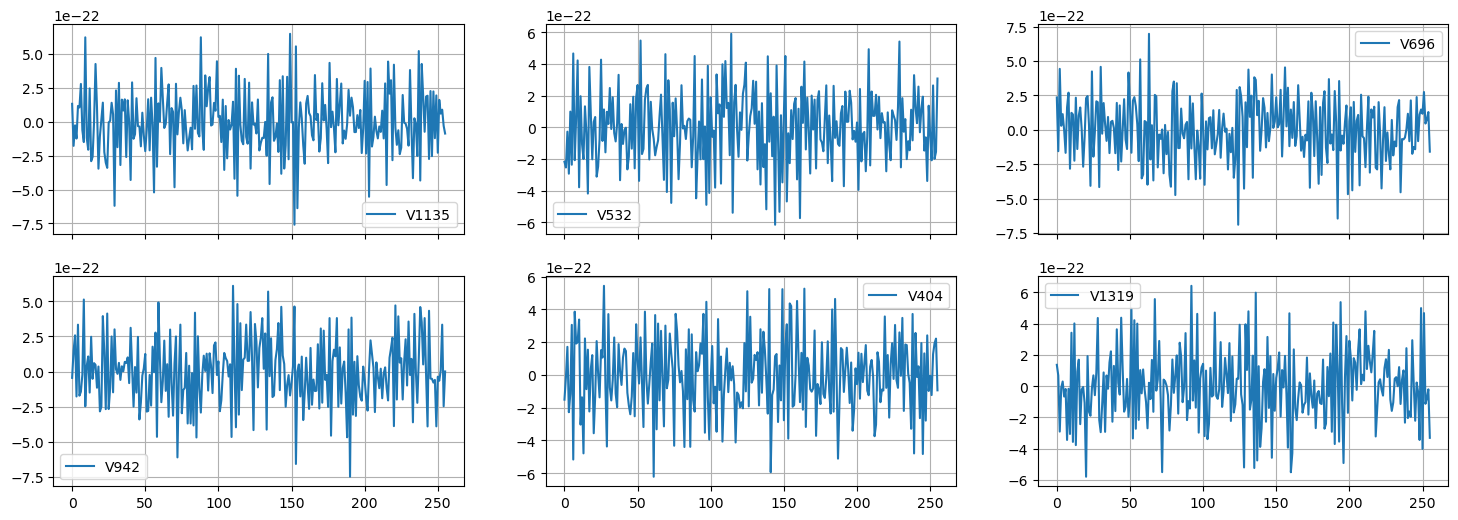

In [12]:
# Plot color noises (time domain) individually
colorNoise.plot(y = V, figsize = (18, 6), grid = True, subplots = True, layout = (2, 3), color = 'C0')
plt.show()

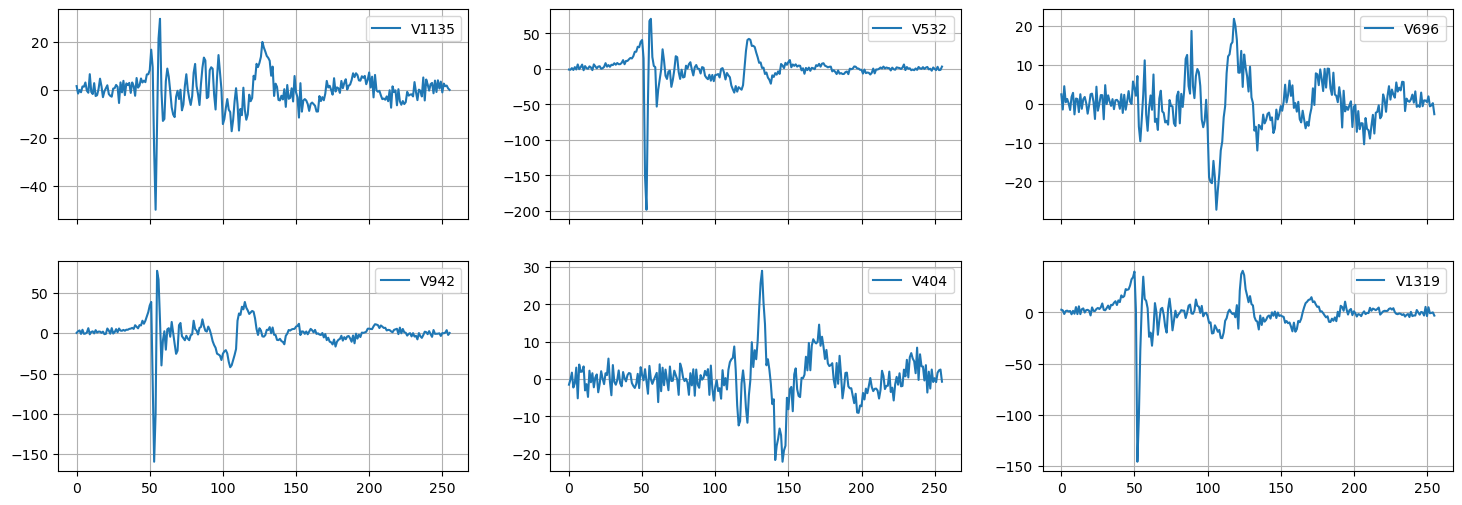

In [13]:
# Standardize the signal and color noise with the same scale
scale = 1e22
df = df * scale
colorNoise = colorNoise * scale
# Superimpose signal and noise
df_add_noise = df + colorNoise
# Plot the superimposed signals individually
df_add_noise.plot(y = V, figsize = (18, 6), grid = True, subplots = True, layout = (2, 3), color = 'C0')
plt.show()

# Deep learning method

## Generate batch data

In [14]:
def batch_data_generator(df_original, df_add_noise, batch_size):
    # Random split train validation test into 70, 15, 15
    X_train, X_valid, X_test = np.split(
        df_add_noise.T.sample(frac = 1, random_state = RANDOM_SEED),
        [int(len(df_add_noise.T) * 0.7), int(len(df_add_noise.T) * 0.85)])
    y_train, y_valid, y_test = df_original.T.loc[X_train.index], df_original.T.loc[X_valid.index], df_original.T.loc[X_test.index]
    # Convert dataframe to tensor
    X_train, X_valid, X_test = torch.Tensor(X_train.to_numpy()), torch.Tensor(X_valid.to_numpy()), torch.Tensor(X_test.to_numpy())
    y_train, y_valid, y_test = torch.Tensor(y_train.to_numpy()), torch.Tensor(y_valid.to_numpy()), torch.Tensor(y_test.to_numpy())
    # Generate batch data
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = True, drop_last = True)
    valid_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size = batch_size, shuffle = True, drop_last = True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size = batch_size, shuffle = True, drop_last = True)
    return train_loader, valid_loader, test_loader

In [15]:
# Load batch data
batch_size = 8
train_loader, valid_loader, test_loader = batch_data_generator(df, df_add_noise, batch_size)

## Modeling

In [16]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Selected device: {device}')

Selected device: cpu


In [17]:
# class Autoencoder(nn.Module):
#     def __init__(self, batch_size):
#         super(Autoencoder, self).__init__()
        
#         self.conv1 = nn.Conv1d(in_channels = batch_size, out_channels = batch_size * 8, kernel_size = 5, stride = 1)
#         self.conv2 = nn.Conv1d(in_channels = batch_size * 8, out_channels = batch_size * 64, kernel_size = 5, stride = 1)
        
#         self.convT1 = nn.ConvTranspose1d(in_channels = batch_size * 64, out_channels = batch_size * 8, kernel_size = 5, stride = 1)
#         self.convT2 = nn.ConvTranspose1d(in_channels = batch_size * 8, out_channels = batch_size, kernel_size = 5, stride = 1)
        
#         # self.pool = nn.MaxPool1d(kernel_size = 2, stride = 2, return_indices = True)
#         # self.unpool = nn.MaxUnpool1d(kernel_size = 2, stride = 2)
#         self.af = nn.PReLU()
        
#     def forward(self, x):
#         # print(x.shape)
#         x = self.conv1(x)
#         # print(x.shape)
#         x = self.af(x)
#         # print(x.shape)
#         x = self.conv2(x)
#         # print(x.shape)
#         x = self.af(x)
#         # print(x.shape)
#         # x, indices = self.pool(x)
#         # x = self.unpool(x, indices)
#         x = self.convT1(x)
#         # print(x.shape)
#         x = self.af(x)
#         # print(x.shape)
#         x = self.convT2(x)
#         # print(x.shape)
#         x = self.af(x)
#         # print(x.shape)
        
#         return x

In [18]:
class Autoencoder(nn.Module):
    def __init__(self, batch_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels = batch_size, out_channels = batch_size * 8, kernel_size = 3, stride = 1),
            nn.PReLU(),
            nn.Conv1d(in_channels = batch_size * 8, out_channels = batch_size * 64, kernel_size = 3, stride = 1),
            nn.PReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels = batch_size * 64, out_channels = batch_size * 8, kernel_size = 3, stride = 1),
            nn.PReLU(),
            nn.ConvTranspose1d(in_channels = batch_size * 8, out_channels = batch_size, kernel_size = 3, stride = 1),
            nn.PReLU()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [19]:
# Initialize the model
model = Autoencoder(batch_size).to(device)
# Set random seed for reproducible results
torch.manual_seed(RANDOM_SEED)
# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
# Number of parameters
parameters = [p.numel() for p in model.parameters() if p.requires_grad]
print(f'Total number of parameters: {sum(parameters)}')

Total number of parameters: 200332


In [20]:
def train(dataloader, model, loss_fn, optimizer):
    loss_list, pred_list, targ_list = [], [], []
    model.train()
    for batch_x, batch_y in dataloader:
        pred = model(batch_x.reshape(1, batch_size, -1))
        pred_list.append(pred)
        
        targ = batch_y.reshape(1, batch_size, -1)
        targ_list.append(targ)
        
        # L1 Regularization
        L1_loss = 0
        loss = loss_fn(pred, targ)
        for param in model.parameters():
            L1_loss += torch.sum(abs(param))
        loss += L1_loss * 0.001
        loss_list.append(loss.item())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return np.mean(loss_list), pred_list, targ_list

In [21]:
def valid(dataloader, model, loss_fn):
    loss_list, pred_list, targ_list = [], [], []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            pred = model(batch_x.reshape(1, batch_size, -1))
            pred_list.append(pred)
            
            targ = batch_y.reshape(1, batch_size, -1)
            targ_list.append(targ)
            
            loss = loss_fn(pred, targ)
            loss_list.append(loss.item())
            
    return np.mean(loss_list), pred_list, targ_list

In [22]:
def test(dataloader, model, loss_fn):
    loss_list, pred_list, targ_list = [], [], []
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            pred = model(batch_x.reshape(1, batch_size, -1))
            pred_list.append(pred)
            
            targ = batch_y.reshape(1, batch_size, -1)
            targ_list.append(targ)
            
            loss = loss_fn(pred, targ)
            loss_list.append(loss.item())
            
    return np.mean(loss_list), pred_list, targ_list

In [23]:
epochs = 300
min_loss = np.inf
epoch_train_loss, epoch_valid_loss = [], []

start = time.time()
for epoch in range(epochs):
    train_loss, train_pred, train_targ = train(train_loader, model, loss_fn, optimizer)
    epoch_train_loss.append(train_loss)
    
    valid_loss, valid_pred, valid_targ = valid(valid_loader, model, loss_fn)
    epoch_valid_loss.append(valid_loss)
    
    if valid_loss < min_loss:
        min_loss = valid_loss
        best_pred = valid_pred
        best_targ = valid_targ
        torch.save(model.state_dict(), 'best_model.pt')
        
    print(f'Epoch [{epoch+1:<3}/{epochs}]   Train Loss: {train_loss:.8f}   Valid Loss: {valid_loss:.8f}')
print(f'{"-"*70}\nDuration: {time.time() - start:.4f} seconds')
print(f'{"-"*70}\nBest Train Loss: {min(epoch_train_loss):.8f}\nBest Valid Loss: {min(epoch_valid_loss):.8f}')

Epoch [1  /300]   Train Loss: 85.54102948   Valid Loss: 36.82094718
Epoch [2  /300]   Train Loss: 31.88271067   Valid Loss: 18.71292033
Epoch [3  /300]   Train Loss: 22.80917101   Valid Loss: 13.64265130
Epoch [4  /300]   Train Loss: 19.40520924   Valid Loss: 10.93264122
Epoch [5  /300]   Train Loss: 17.26272517   Valid Loss: 9.82062733
Epoch [6  /300]   Train Loss: 16.25465558   Valid Loss: 8.47338016
Epoch [7  /300]   Train Loss: 15.53893876   Valid Loss: 7.84196082
Epoch [8  /300]   Train Loss: 14.75939948   Valid Loss: 7.30042378
Epoch [9  /300]   Train Loss: 14.31564364   Valid Loss: 6.88411597
Epoch [10 /300]   Train Loss: 13.80741349   Valid Loss: 6.68238732
Epoch [11 /300]   Train Loss: 13.50526486   Valid Loss: 6.13848995
Epoch [12 /300]   Train Loss: 13.22975660   Valid Loss: 5.97634552
Epoch [13 /300]   Train Loss: 12.94496426   Valid Loss: 5.90232331
Epoch [14 /300]   Train Loss: 12.69945156   Valid Loss: 5.42084353
Epoch [15 /300]   Train Loss: 12.45775851   Valid Loss: 5.

## Outcome

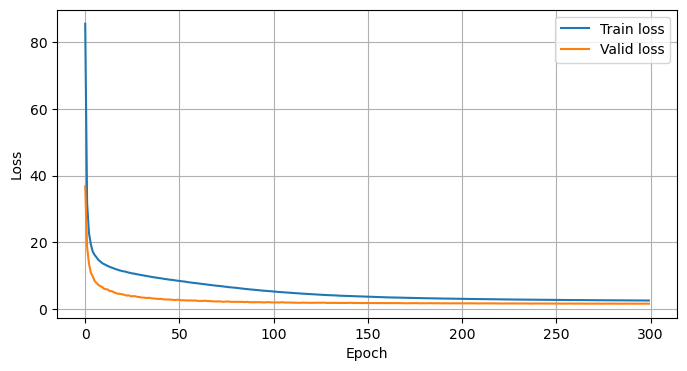

In [24]:
# Plot training and validation loss curves
plt.figure(figsize = (8, 4))
plt.plot(epoch_train_loss, label = 'Train loss')
plt.plot(epoch_valid_loss, label = 'Valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

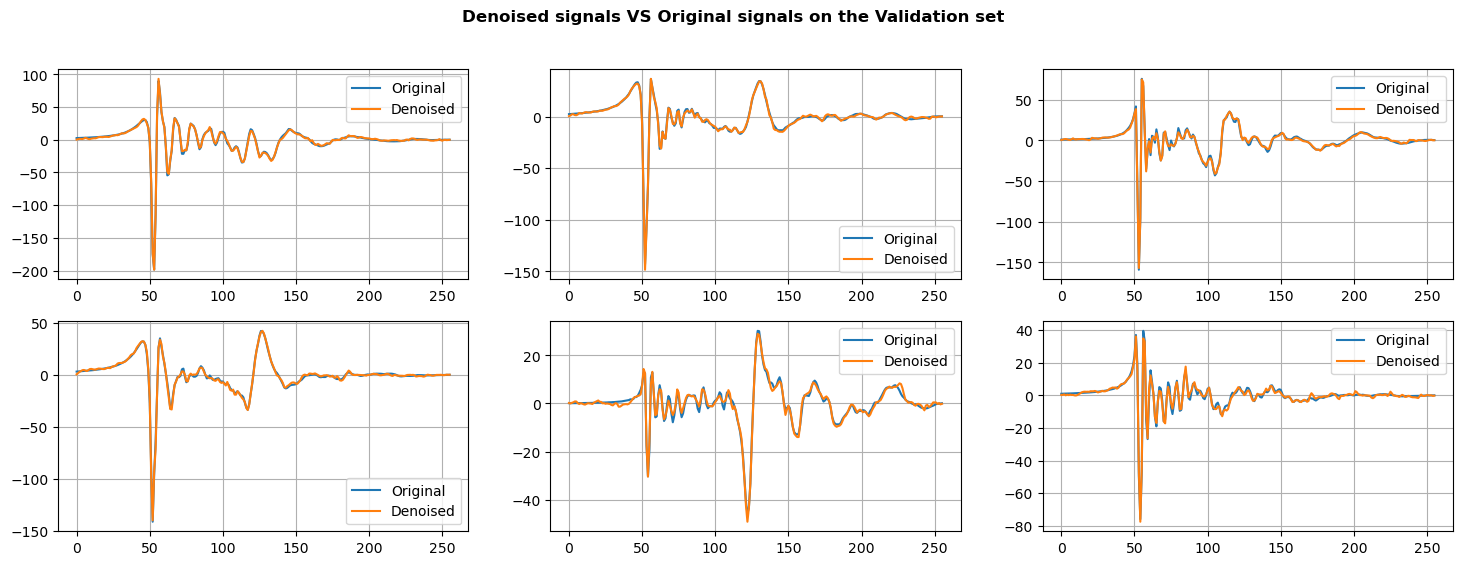

In [25]:
# Compare denoised signals and original signals on validation set
fig, axs = plt.subplots(2, 3, figsize = (18, 6))
for i in range(2):
    for j in range(3):
        a = random.randint(0, len(valid_loader) - 1)
        b = random.randint(0, batch_size - 1)
        axs[i, j].plot(best_targ[a][0][b].detach().numpy())
        axs[i, j].plot(best_pred[a][0][b].detach().numpy())
        axs[i, j].legend(['Original', 'Denoised'])
        axs[i, j].grid()
fig.suptitle('Denoised signals VS Original signals on the Validation set', fontweight = 'bold')
plt.show()

In [26]:
# Test the model
test_loss, test_pred, test_targ = test(test_loader, model, loss_fn)
print(f'Test Loss: {test_loss:.8f}')

Test Loss: 1.65594676


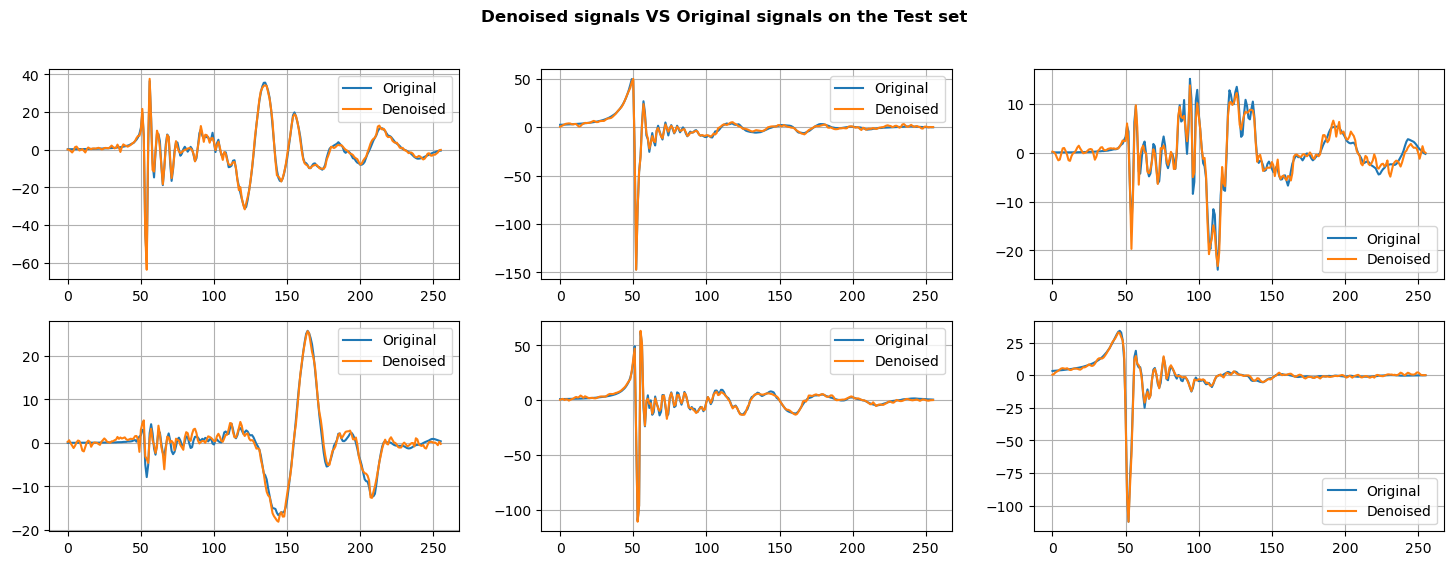

In [27]:
# Compare denoised signals and original signals on test set
fig, axs = plt.subplots(2, 3, figsize = (18, 6))
for i in range(2):
    for j in range(3):
        a = random.randint(0, len(test_loader) - 1)
        b = random.randint(0, batch_size - 1)
        axs[i, j].plot(test_targ[a][0][b].detach().numpy())
        axs[i, j].plot(test_pred[a][0][b].detach().numpy())
        axs[i, j].legend(['Original', 'Denoised'])
        axs[i, j].grid()
fig.suptitle('Denoised signals VS Original signals on the Test set', fontweight = 'bold')
plt.show()

In [28]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

## Robustness verification

In [ ]:
noise_scale_lst, rand_select_test_targ, rand_select_test_pred = [], [], []
best_train_loss_lst, best_valid_loss_lst, test_loss_lst = [], [], []
df_and_noise_lst = []
# Randomly select 1 signal
V = 'V' + str(random.randint(1, df.shape[1]))
start = time.time()
# Standardize the color noise with varying scales
for i in [1, 2, 4, 6, 8, 10]:
    colorNoise_scaled = colorNoise * i
    # Superimpose signal and noise
    df_and_noise = df + colorNoise_scaled
    df_and_noise_lst.append(df_and_noise[V])
    # Load batch data
    train_loader, valid_loader, test_loader = batch_data_generator(df, df_and_noise, batch_size)
    # Initialize the model
    model = Autoencoder(batch_size).to(device)
    # Set random seed for reproducible results
    torch.manual_seed(RANDOM_SEED)
    # Define loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
    # Train the model
    epochs = 300
    min_loss = np.inf
    epoch_train_loss, epoch_valid_loss = [], []
    for epoch in range(epochs):
        train_loss, train_pred, train_targ = train(train_loader, model, loss_fn, optimizer)
        epoch_train_loss.append(train_loss)
        valid_loss, valid_pred, valid_targ = valid(valid_loader, model, loss_fn)
        epoch_valid_loss.append(valid_loss)
        if valid_loss < min_loss:
            min_loss = valid_loss
            best_pred = valid_pred
            best_targ = valid_targ
            torch.save(model.state_dict(), 'best_model.pt')
    # Test the model
    test_loss, test_pred, test_targ = test(test_loader, model, loss_fn)
    # Randomly select 1 test result to plot
    a = random.randint(0, len(test_loader) - 1)
    b = random.randint(0, batch_size - 1)
    rand_select_test_targ.append(test_targ[a][0][b].detach().numpy())
    rand_select_test_pred.append(test_pred[a][0][b].detach().numpy())
    # Save the losses under different noise scales
    noise_scale_lst.append(scale * i)
    best_train_loss_lst.append(min(epoch_train_loss))
    best_valid_loss_lst.append(min(epoch_valid_loss))
    test_loss_lst.append(test_loss)
    # Print the results
    print(f'Noise Scale: {scale * i}   Best Train Loss: {min(epoch_train_loss):.8f}   Best Valid Loss: {min(epoch_valid_loss):.8f}   Test Loss: {test_loss:.8f}')
print(f'{"-"*110}\nDuration: {time.time() - start:.4f} seconds')

In [ ]:
# Plot the same signal superimposed with different noise scales
fig, axs = plt.subplots(2, 3, figsize = (18, 6))
for i in range(2):
    for j in range(3):
        k = int(str(i) + str(j), 3)
        axs[i, j].set_title(f'Noise scale: {noise_scale_lst[k]}')
        axs[i, j].plot(df_and_noise_lst[k], label = V)
        axs[i, j].legend()
        axs[i, j].grid()
fig.suptitle('The same signal under different noise scales', fontweight = 'bold')
plt.subplots_adjust(hspace = 0.3)
plt.show()

In [ ]:
# Plot loss changes vs noise scale
plt.figure(figsize = (8, 4))
plt.xticks(range(0, 6), noise_scale_lst)
plt.plot(best_train_loss_lst, label = 'Train loss', marker = 'o')
plt.plot(best_valid_loss_lst, label = 'Valid loss', marker = 's')
plt.plot(test_loss_lst, label = 'Test loss', marker = 'v')
plt.title('Loss changes VS Noise scales', fontweight = 'bold')
plt.xlabel('Noise scales')
plt.ylabel('Loss changes')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Compare denoised signals and original signals
fig, axs = plt.subplots(2, 3, figsize = (18, 6))
for i in range(2):
    for j in range(3):
        k = int(str(i) + str(j), 3)
        axs[i, j].set_title(f'Noise scale: {noise_scale_lst[k]}')
        axs[i, j].plot(rand_select_test_targ[k])
        axs[i, j].plot(rand_select_test_pred[k])
        axs[i, j].legend(['Original', 'Denoised'])
        axs[i, j].grid()
fig.suptitle('Denoised signals VS Original signals under different noise scales', fontweight = 'bold')
plt.subplots_adjust(hspace = 0.3)
plt.show()

# PCR method

## Preparation

In [ ]:
# Load packages
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [ ]:
# Random split train test into 70, 30
X_train = df_add_noise.T.sample(frac = 0.7, random_state = RANDOM_SEED)
X_test = df_add_noise.T.drop(X_train.index)
y_train, y_test = df.T.loc[X_train.index], df.T.loc[X_test.index]

## Modeling

In [ ]:
pca = PCA(n_components = 10)
X_train_PCA = pca.fit_transform(X_train)
np.fft.fft(X_train_PCA)

In [ ]:
def PCR(N, X_train, X_test, y_train, y_test):
    # Select number of components or explained variance ratio
    pca = PCA(n_components = N)
    # Apply the dimensionality reduction on X_train
    X_train_PCA = pca.fit_transform(X_train)
    r = sum(pca.explained_variance_ratio_)
    # Fit linear model
    regression = LinearRegression()
    regression.fit(X_train_PCA, y_train)
    # Apply the dimensionality reduction on X_test
    X_test_PCA = pca.transform(X_test)
    # Make predictions on test set
    y_pred = regression.predict(X_test_PCA)
    MSE = mean_squared_error(y_test, y_pred)
    return pd.DataFrame(y_pred, index = y_test.index), r, MSE

In [ ]:
# Find the min test MSE
y_list, r_list, MSE_list = [], [], []
# Set the number of components range
N_range = np.arange(1, X_train.shape[1] + 1)
for N in N_range:
    y_pred, r, MSE = PCR(N, X_train, X_test, y_train, y_test)
    r_list.append(r)
    MSE_list.append(MSE)
    y_list.append(y_pred)
print(f'Min MSE on test set: {min(MSE_list):.8f}')
print(f'Required number of components: [{N_range[MSE_list.index(min(MSE_list))]}/{X_train.shape[1]}]')
print(f'Total explained variance ratio: {r_list[MSE_list.index(min(MSE_list))]:.8f}')

In [ ]:
# Plot explained variance ratio and MSE at different number of components
fig, ax1 = plt.subplots(figsize = (8, 4))
# Plot MSE curve
ax1.plot(N_range, MSE_list, label = 'Mean squared error (Test)')
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Mean squared error (Test)', color = 'C0')
ax1.tick_params(axis = 'y', labelcolor = 'C0')
ax1.grid()
# Share x-axis
ax2 = ax1.twinx()
# Plot the explained variance ratio curve
ax2.plot(N_range, r_list, color = 'C1', label = 'Explained variance ratio')
ax2.set_ylabel('Explained variance ratio', color = 'C1')
ax2.tick_params(axis = 'y', labelcolor = 'C1')
# Legend
fig.legend(bbox_to_anchor = (0.7, 0.56))
plt.show()

In [ ]:
# Compare denoised signals and original signals on test set
V = random.sample(y_test.index.to_list(), 6)
best_y_pred = y_list[MSE_list.index(min(MSE_list))]
ax = y_test.T.plot(y = V, figsize = (18, 6), grid = True, subplots = True,
                   layout = (2, 3), color = 'C0', label = ['Original'] * 6, title = V)
best_y_pred.T.plot(y = V, figsize = (18, 6), grid = True, subplots = True,
              layout = (2, 3), color = 'C1', label = ['Denoised'] * 6, ax = ax)
plt.suptitle('Denoised signals VS Original signals on the Test set', fontweight = 'bold')
plt.show()

## Cross validation

In [ ]:
def PCR_CV(n_fold, df_add_noise, RANDOM_SEED):
    min_n_list, min_r_list, min_MSE_list = [], [], []
    kf = KFold(n_splits = n_fold, shuffle = True, random_state = RANDOM_SEED)
    for train_index, test_index in kf.split(df_add_noise.T):
        X_train, X_test = df_add_noise.T.iloc[train_index], df_add_noise.T.iloc[test_index]
        y_train, y_test = df.T.iloc[train_index], df.T.iloc[test_index]
        # Train the model
        # Find the min test MSE
        r_list, MSE_list = [], []
        # Set the number of components range
        N_range = np.arange(100, X_train.shape[1] + 1)
        for N in N_range:
            _, r, MSE = PCR(N, X_train, X_test, y_train, y_test)
            r_list.append(r)
            MSE_list.append(MSE)
        # Save the min test MSE, number of components and explained variance ratio
        min_MSE_list.append(min(MSE_list))
        min_r_list.append(r_list[MSE_list.index(min(MSE_list))])
        min_n_list.append(N_range[MSE_list.index(min(MSE_list))])
    return min_MSE_list, min_n_list, min_r_list

In [ ]:
# 5-Fold cross validation
n_fold = 5
min_MSE_list, min_n_list, min_r_list = PCR_CV(n_fold, df_add_noise, RANDOM_SEED)

In [ ]:
# Plot explained variance ratio and MSE for each fold
fig, ax1 = plt.subplots(figsize = (8, 4))
# Plot number of components bar chart
ax1.bar(range(1, n_fold + 1), min_n_list, width = 0.2, color = 'C1', label = 'Number of components', alpha = 0.3)
ax1.set_xticks(range(1, n_fold + 1), ['Fold ' + str(x) for x in range(1, n_fold + 1)])
ax1.set_yticks([])
ax1.set_ylim(top = 280)
# Share x-axis
ax2 = ax1.twinx()
# Plot MSE curve
ax2.plot(range(1, n_fold + 1), min_MSE_list, color = 'C3', label = 'Mean squared error (Test)', marker = 'o')
ax2.set_ylabel('Mean squared error (Test)', color = 'C3', labelpad = -480)
ax2.set_ylim(bottom = 0, top = max(min_MSE_list) + 1)
ax2.tick_params(axis = 'y', labelcolor = 'C3')
# Share x-axis
ax3 = ax2.twinx()
# Plot the explained variance ratio curve
ax3.plot(range(1, n_fold + 1), min_r_list, color = 'C0', label = 'Explained variance ratio', marker = 's', linestyle = '-.')
ax3.set_ylabel('Explained variance ratio', color = 'C0')
ax3.set_ylim(bottom = 0.9, top = 1.3)
ax3.tick_params(axis = 'y', labelcolor = 'C0')
# Legend and text
fig.legend(bbox_to_anchor = (0.96, 0.05), ncol = 3, frameon = False)
for i in range(0, n_fold):
    ax1.text(i + 1, min_n_list[i] + 5, f'{min_n_list[i]}', ha = 'center', color = 'C1')
    ax2.text(i + 1, min_MSE_list[i] + 0.1, f'{min_MSE_list[i]:.4}', ha = 'center', color = 'C3')
    ax3.text(i + 1, min_r_list[i] + 0.02, f'{min_r_list[i]:.4}', ha = 'center', color = 'C0')
plt.show()

## Robustness verification

In [ ]:
noise_scale_lst, rand_select_test_targ, rand_select_test_pred = [], [], []
best_MSE_list, best_n_list, best_r_list = [], [], []
start = time.time()
# Standardize the color noise with varying scales
for i in [1, 2, 4, 6, 8, 10]:
    colorNoise_scaled = colorNoise * i
    # Superimpose signal and noise
    df_and_noise = df + colorNoise_scaled
    # Random split train test into 70, 30
    X_train = df_and_noise.T.sample(frac = 0.7, random_state = RANDOM_SEED)
    X_test = df_and_noise.T.drop(X_train.index)
    y_train, y_test = df.T.loc[X_train.index], df.T.loc[X_test.index]
    # Train the model
    y_list, r_list, MSE_list = [], [], []
    # Set the number of components range
    N_range = np.arange(1, X_train.shape[1] + 1)
    for N in N_range:
        y_pred, r, MSE = PCR(N, X_train, X_test, y_train, y_test)
        r_list.append(r)
        MSE_list.append(MSE)
        y_list.append(y_pred)
    # Find the min test MSE
    best_MSE = min(MSE_list)
    best_n = N_range[MSE_list.index(best_MSE)]
    best_r = r_list[MSE_list.index(best_MSE)]
    best_y = y_list[MSE_list.index(best_MSE)]
    # Save the best result under different noise scales
    noise_scale_lst.append(scale * i)
    best_MSE_list.append(best_MSE)
    best_n_list.append(best_n)
    best_r_list.append(best_r)
    # Randomly select 1 test result to plot
    a = random.choice(best_y.index)
    rand_select_test_targ.append(y_test.loc[a])
    rand_select_test_pred.append(best_y.loc[a])
    # Print the results
    print(f'Noise Scale: {scale * i}   Best Test MSE: {best_MSE:.8f}   Number of Components: [{best_n}/256]   Explained Variance Ratio: {best_r:.8f}')
print(f'{"-"*120}\nDuration: {time.time() - start:.4f} seconds')

In [ ]:
# Plot explained variance ratio and MSE under different noise scales
fig, ax1 = plt.subplots(figsize = (8, 4))
# Plot number of components bar chart
ax1.bar(range(1, 6 + 1), best_n_list, width = 0.2, color = 'C1', label = 'Number of components', alpha = 0.3)
ax1.set_xticks(range(1, 6 + 1), noise_scale_lst)
ax1.set_yticks([])
ax1.set_ylim(top = 280)
# Share x-axis
ax2 = ax1.twinx()
# Plot MSE curve
ax2.plot(range(1, 6 + 1), best_MSE_list, color = 'C3', label = 'Mean squared error (Test)', marker = 'o')
ax2.set_ylabel('Mean squared error (Test)', color = 'C3', labelpad = -480)
ax2.set_ylim(bottom = 0, top = max(best_MSE_list) + 5)
ax2.tick_params(axis = 'y', labelcolor = 'C3')
# Share x-axis
ax3 = ax2.twinx()
# Plot the explained variance ratio curve
ax3.plot(range(1, 6 + 1), best_r_list, color = 'C0', label = 'Explained variance ratio', marker = 's', linestyle = '-.')
ax3.set_ylabel('Explained variance ratio', color = 'C0')
ax3.set_ylim(bottom = 0.9, top = 1.3)
ax3.tick_params(axis = 'y', labelcolor = 'C0')
# Legend and text
fig.legend(bbox_to_anchor = (0.96, 0.05), ncol = 3, frameon = False)
for i in range(0, 6):
    ax1.text(i + 1, best_n_list[i] + 5, f'{best_n_list[i]}', ha = 'center', color = 'C1')
    ax2.text(i + 1, best_MSE_list[i] + 1, f'{best_MSE_list[i]:.4}', ha = 'center', color = 'C3')
    ax3.text(i + 1, best_r_list[i] + 0.01, f'{best_r_list[i]:.4}', ha = 'center', color = 'C0')
plt.show()

In [ ]:
# Compare denoised signals and original signals
fig, axs = plt.subplots(2, 3, figsize = (18, 6))
for i in range(2):
    for j in range(3):
        k = int(str(i) + str(j), 3)
        axs[i, j].set_title(f'Noise scale: {noise_scale_lst[k]}')
        axs[i, j].plot(rand_select_test_targ[k])
        axs[i, j].plot(rand_select_test_pred[k])
        axs[i, j].legend(['Original', 'Denoised'])
        axs[i, j].grid()
fig.suptitle('Denoised signals VS Original signals under different noise scales', fontweight = 'bold')
plt.subplots_adjust(hspace = 0.3)
plt.show()